<a href="https://colab.research.google.com/github/ceasoto/MLA_Clase01/blob/main/Tarea_1_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Redes Neuronales
Integrantes:
- Kurt Castro
- Diego León
- César Soto

## Introducción

El presente informe se centra en el análisis de una base de datos que contiene información médica de pacientes, originalmente compuesta por 76 atributos. Sin embargo, los estudios previos y experimentos publicados han utilizado un subconjunto de 14 atributos, seleccionados para simplificar y optimizar los modelos de aprendizaje automático. La base de datos de Cleveland es la única versión que ha sido utilizada hasta el momento en investigaciones en este campo.

El objetivo principal de esta base de datos es identificar la presencia de enfermedad cardíaca en los pacientes, lo cual se representa en el campo "target" mediante un valor binario: 0 para ausencia de la enfermedad y 1 para su presencia. Los estudios realizados se han enfocado en distinguir entre ambos estados, explorando la capacidad de los modelos para clasificar correctamente los casos con y sin enfermedad.


## Metodología

**1. Carga y Preprocesamiento de Datos:**

Se obtendrá el conjunto de datos "Heart Disease" desde el repositorio de la UCI.
Se definirán los nombres de las columnas para facilitar la manipulación de los datos.
Se reemplazarán los valores faltantes ("?") con valores NaN para su posterior tratamiento.
Se convertirá la variable objetivo ('target') a binaria (0: sin enfermedad, 1: con enfermedad).
Se eliminarán las filas con valores NaN para asegurar la calidad de los datos.
Se verificará el balanceo de las clases en la variable objetivo para determinar si se necesitan técnicas de balanceo.

**2. Preparación de los Datos:**

Se realizará la codificación one-hot encoding de las variables categóricas utilizando pd.get_dummies. Esto creará nuevas columnas binarias para cada categoría de las variables categóricas.
Se separará el conjunto de datos en variables predictoras (X) y variable objetivo (y).
Se dividirá el conjunto de datos en conjuntos de entrenamiento y prueba (70% y 30%, respectivamente) utilizando train_test_split.
Se estandarizarán las variables numéricas seleccionadas utilizando StandardScaler para mejorar el rendimiento del modelo.

**3. Modelación con Red Neuronal:**

Se definirá la arquitectura de la red neuronal utilizando la librería Keras.
Se experimentará con diferentes cantidades de nodos en la capa oculta para optimizar el rendimiento. Adicionalmente, se experimenta añadir más épocas de entrenamiento y se compara con añadir más nodos en capa oculta. Para los experimentos se toma de base el laboratorio práctico de la primera clase del curso.
Se entrenará el modelo utilizando el conjunto de entrenamiento y se evaluará su rendimiento en el conjunto de prueba.

**4. Evaluación del Modelo:**

Se utilizará la precisión (accuracy) como métrica principal para evaluar el rendimiento del modelo.
Se analizará la estabilidad del entrenamiento ejecutando el modelo varias veces y calculando la precisión promedio.
Se generarán predicciones en el conjunto de prueba y se comparará con los valores reales para calcular la precisión final.

**5. Análisis y Conclusiones:**

Se analizan los resultados obtenidos, incluyendo la precisión, la estabilidad del entrenamiento, la influencia de los hiperparámetros y los patrones identificados en los datos.
Se extraen conclusiones sobre la efectividad del modelo para predecir enfermedades cardíacas y se discuten las limitaciones y posibles mejoras.

##  Carga y Preprocesamiento de Datos

In [20]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

Dataset disponible en UCI. La variable target es binaria y representa la presencia o no presencia de un defecto cardiaco

In [2]:
# URL del archivo de Heart Disease en la UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]

data = pd.read_csv(url, names=column_names)
data.replace("?", pd.NA, inplace=True)
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**Descripción de las 14 columnas de las 76 del dataset original**

1.   (age)       Edad en años
2.   (sex)       (1 = Masculino; 0 = Femenino)
3.   (cp)        Tipo de dolor de pecho:
              -- Value 1: angina típica
              -- Value 2: angina atípica
              -- Value 3: dolor no anginoso
              -- Value 4: asintomático
4.   (trestbps)  Presión arterial en reposo (en mm Hg al momento de la admisión al hospital)
5.   (chol)      Colesterol sérico en mg/dl
6.   (fbs)       (Glucemia en ayunas > 120 mg/dl) (1 = verdadero; 0 = falso)
7.   (restecg)   Resultados del electrocardiograma en reposo:
               -- Valor 0: normal
               -- Valor 1: con anomalía de la onda ST-T (inversiones de la onda T y/o elevación o depresión de ST de > 0.05 mV)
               -- Valor 2: muestra probable o definida hipertrofia ventricular izquierda según los criterios de Estes
8.     (thalach)   Frecuencia cardíaca máxima alcanzada
9.     (exang)     Angina inducida por ejercicio (1 = sí; 0 = no)
10.    (oldpeak)  Depresión del segmento ST inducida por el ejercicio en relación con el reposo
11.    (slope)    La pendiente del segmento ST en el pico del ejercicio:
                -- Valor 1: ascendente
                -- Valor 2: plano
                -- Valor 3: descendente
12.     (ca)       Número de vasos principales (0-3) coloreados por fluoroscopia
13.     (thal)     3 = normal; 6 = defecto fijo; 7 = defecto reversible
14.     (num)      Diagnóstico de enfermedad cardíaca (estado de la enfermedad angiográfica):
                -- Valor 0: estrechamiento del diámetro < 50%
                -- Valor 1: estrechamiento del diámetro > 50%

In [3]:
data.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


Se puede ver que existen escasos valores nulos en variables categóricas, por lo cual se opta por eliminarlas

In [4]:
data.dropna(inplace=True)

In [5]:
data['target'].value_counts(normalize=True)

,proportion
target,
0,0.538721
1,0.461279


Se puede observar que las clases están prácticamente balanceadas, por lo que no es necesario aplicar técnicas de balanceo

## Preparación de los Datos

Codificación de variables categóricas. Cada categoría se codifica por separado para cada variable categórica de 3 o más categorías (ya que las de 2 categorías son binarias)

In [6]:
cat_cols = ['cp', 'restecg', 'slope', 'ca', 'thal']
prepared_data = pd.get_dummies(data, columns = cat_cols)
X = prepared_data.drop(['target'], axis = 1)
y = prepared_data['target']
prepared_data.head(5)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_1.0,...,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,True,...,False,False,True,True,False,False,False,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,False,...,False,True,False,False,False,False,True,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,False,...,False,True,False,False,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,False,...,False,False,True,True,False,False,False,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,False,...,True,False,False,True,False,False,False,True,False,False


se puede ver por ejemplo que la variable slope se dividió en 3 variables binarias para sus 3 categorías

Se dividen los datos conservando un 30% para testing

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [8]:
X_train.shape, X_test.shape

((207, 25), (90, 25))

In [9]:
y_train.shape, y_test.shape

((207,), (90,))

Se normalizan las variables numéricas usando Standard Scaler

In [11]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
columns_to_scale = ["age", "trestbps", "chol", "thalach", "oldpeak"] # solo en las numericas de interés para normalizar
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])
X_train_scaled = np.asarray(X_train_scaled).astype(np.float32)
X_test_scaled = np.asarray(X_test_scaled).astype(np.float32)

## Modelación con Red Neuronal

Función customizada de matriz de confusión

In [12]:
def custom_confusion_matrix(y_test, y_pred, display_labels):
  cm = confusion_matrix(y_test, y_pred)
  cm_norm = confusion_matrix(y_test, y_pred, normalize = 'true')

  fig, ax = plt.subplots(1, 2, figsize=(16, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot(cmap=plt.cm.Blues, ax = ax[0])

  disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=display_labels)
  disp.plot(cmap=plt.cm.Blues, ax = ax[1])

  ax[0].set_title("Non-normalized confusion matrix")
  ax[1].set_title("Normalized confusion matrix")
  plt.tight_layout()

Hiper-parámetros iniciales

In [13]:
hidden_units = 10  # numero de neuronas en la capa oculta
activation = 'relu'  # tipo de activacion
l2_reg = 0.01   # regularizacion cuanta mas alta es la penalizacion

learning_rate = 0.01  # factor de aprendizaje
epochs = 10             # numero de iteraciones para entrenamiento
batch_size = 32       # tamaño de la muestra


### Experimentación en nodos en capa oculta

10 nodos en capa oculta

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5669 - loss: 0.6841
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7750 - loss: 0.4925  
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - loss: 0.4351 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8405 - loss: 0.3972 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.3632 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.3368 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.3206 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.3097 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8758 - loss: 0.3005 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8826 - loss: 0.2923 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8611 - loss: 0.2836
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8597 - loss: 0.3543
Train accuracy: 0.89
Test accuracy:

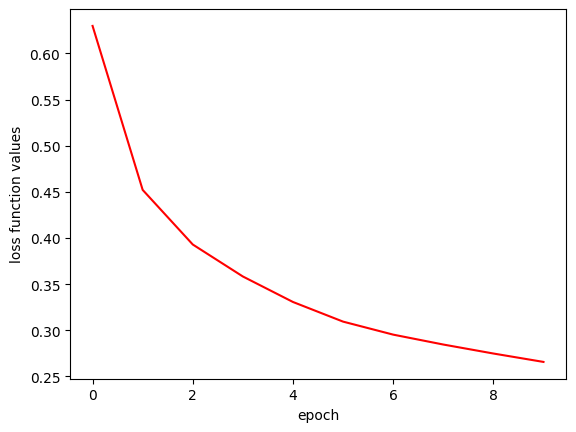

In [23]:
model = models.Sequential() # create a sequential model
model.add(layers.Dense(input_dim=len(X.columns),
                       units=hidden_units,
                       activation=activation)) # add a hidden layer with 10 units to the model
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid')) #output layer
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy']) #compile model

history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size) #Train the parameters

train_acc=model.evaluate(X_train_scaled, y_train, batch_size=batch_size)[1] #Evaluate the model
test_acc=model.evaluate(X_test_scaled, y_test, batch_size=batch_size)[1] #

print(f'Train accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss function values')
plt.show()

Se puede ver que la función de pérdida decrece hasta converger, resultando en un accuracy en test de aprox. 83%, lo cual ya indica un alto nivel de generalización del modelo

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        49
           1       0.85      0.80      0.82        41

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.84      0.84      0.84        90



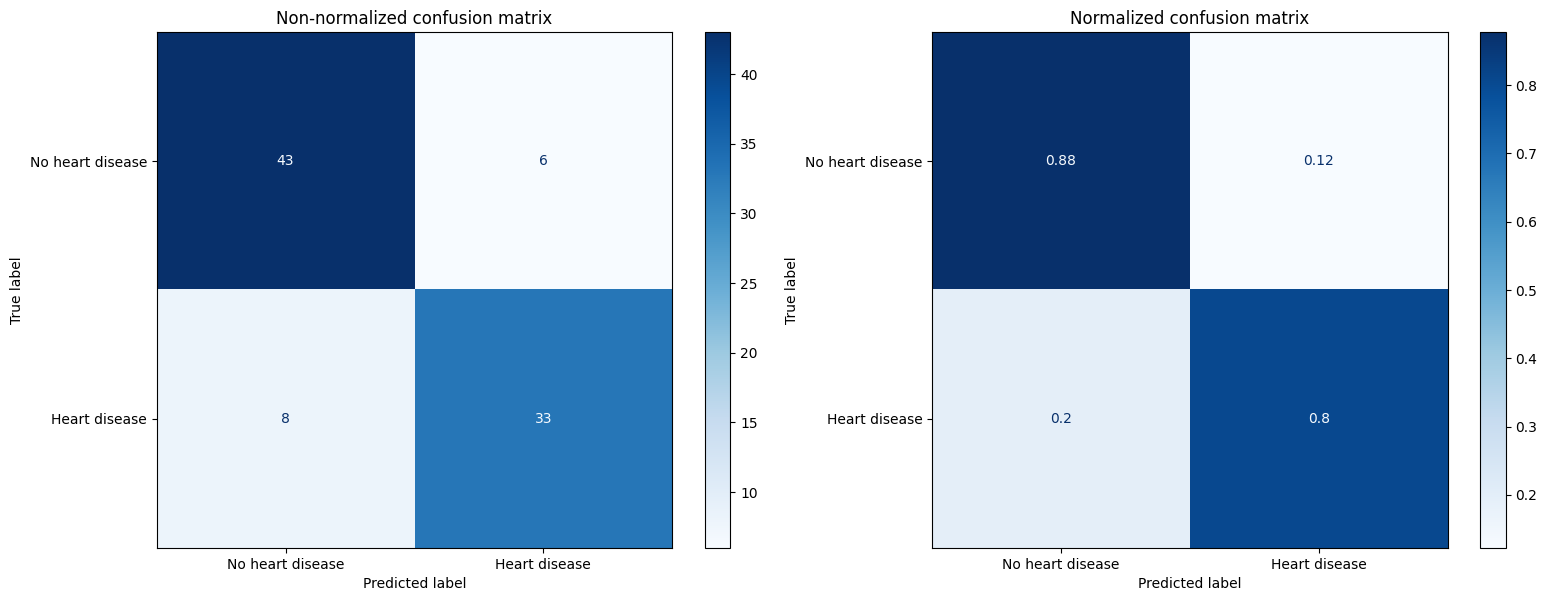

In [24]:
test_predictions = (model.predict(X_test_scaled, verbose = 0) > 0.5).astype(int)
custom_confusion_matrix(y_test, test_predictions, ['No heart disease', 'Heart disease'])
print(classification_report(y_test, test_predictions))

En los detalles de resultados por clase, se puede ver un macro-recall y f1-score en torno al 83% y
un recall de 80% sobre la clase que se quiere detectar (Heart Disease). Esto muestra que para ambas
clases tiene un adecuado nivel inicial de rendimiento

20 unidades en capa oculta

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5865 - loss: 0.6507
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7838 - loss: 0.4545 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8104 - loss: 0.4006 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8377 - loss: 0.3601 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8680 - loss: 0.3181 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.2931 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8963 - loss: 0.2763 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.2564 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9008 - loss: 0.2404 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9079 - loss: 0.2225 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9105 - loss: 0.2013
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8441 - loss: 0.4603
Training accuracy: 0.93
Test accurac

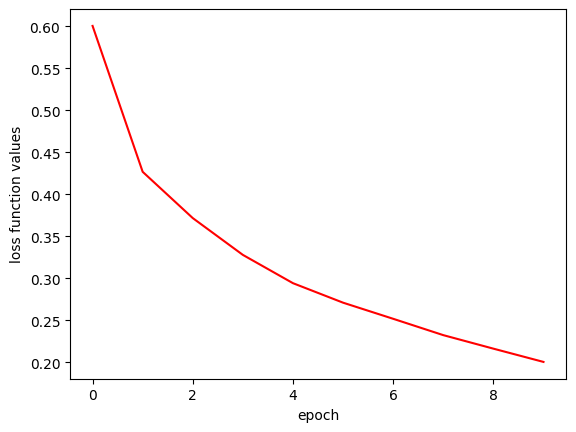

In [25]:
hidden_units=20 # nodos de capas ocultas iniciales

# create model
model = models.Sequential()

# aprimera capa oculta de 10 nodos
model.add(layers.Dense(input_dim=len(X.columns),
                       units=hidden_units,
                       activation=activation))
#segunda capa oculta de 10 nodos
model.add(layers.Dense(input_dim=hidden_units,
                       units=hidden_units,
                       activation=activation))

# ultima capa oculta de 1 nodo
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#traint the parameters
history = model.fit(X_train_scaled, y_train,
                    epochs=10,
                    batch_size=batch_size)

#evalute the accuracy
train_acc=model.evaluate(X_train_scaled, y_train, batch_size=32)[1]
test_acc=model.evaluate(X_test_scaled, y_test, batch_size=32)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss function values')
plt.show()

Se observa un aumento en training accuracy, pero en testing queda prácticamente igual. Se observa además que en este caso la función de pérdida aún no converge por completo

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        49
           1       0.84      0.78      0.81        41

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90



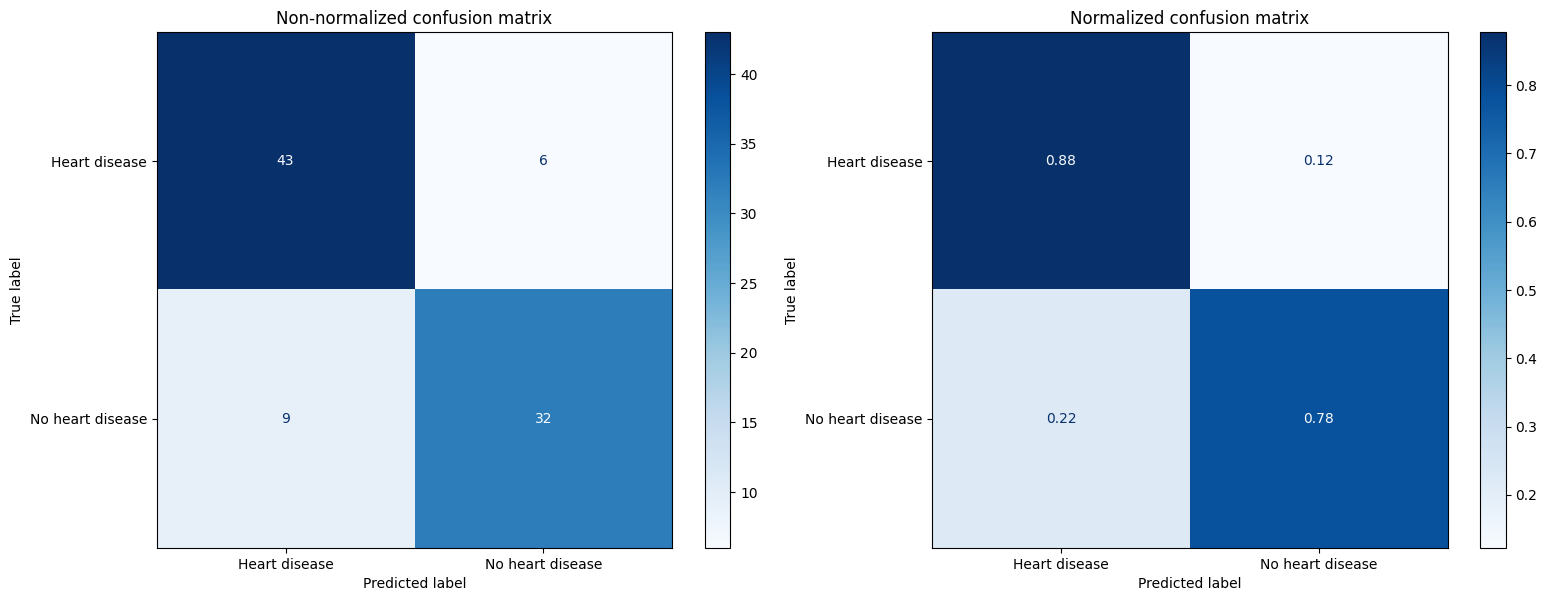

In [19]:
test_predictions = (model.predict(X_test_scaled, verbose = 0) > 0.5).astype(int)
custom_confusion_matrix(y_test, test_predictions, ['Heart disease', 'No heart disease'])
print(classification_report(y_test, test_predictions))

30 unidades en capa oculta

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6612 - loss: 0.6308
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8150 - loss: 0.4067
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3322 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8867 - loss: 0.2620 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8854 - loss: 0.2844 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.3172 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.2149 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.1666 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.1931 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9322 - loss: 0.1644 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9362 - loss: 0.1700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8313 - loss: 0.4636
Training accuracy: 0.94
Test accuracy

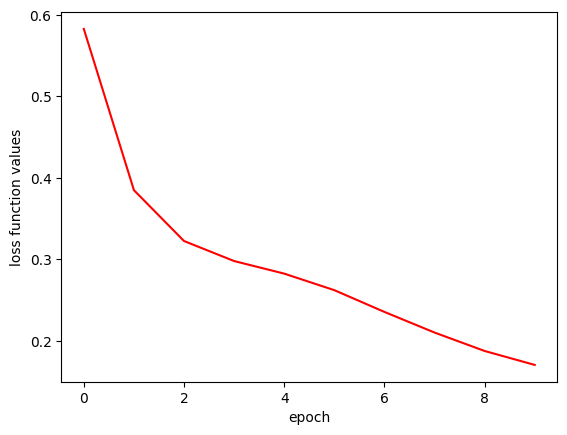

In [ ]:
hidden_units=30 # nodos de capas ocultas iniciales

# create model
model = models.Sequential()

# aprimera capa oculta de 10 nodos
model.add(layers.Dense(input_dim=len(X.columns),
                       units=hidden_units,
                       activation=activation))
#segunda capa oculta de 10 nodos
model.add(layers.Dense(input_dim=hidden_units,
                       units=hidden_units,
                       activation=activation))

# ultima capa oculta de 1 nodo
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#traint the parameters
history = model.fit(X_train_scaled, y_train,
                    epochs=10,
                    batch_size=batch_size)

#evalute the accuracy
train_acc=model.evaluate(X_train_scaled, y_train, batch_size=32)[1]
test_acc=model.evaluate(X_test_scaled, y_test, batch_size=32)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss function values')
plt.show()

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        49
           1       0.76      0.85      0.80        41

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.82      0.81      0.81        90



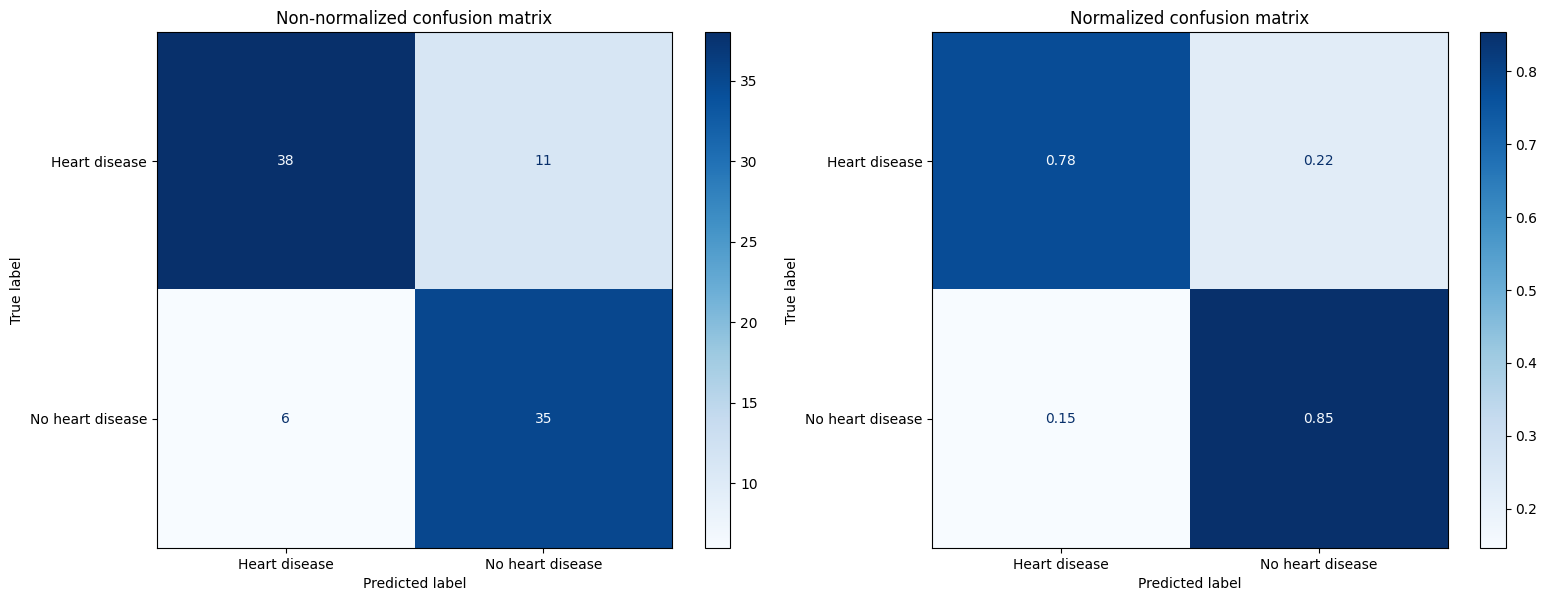

In [ ]:
test_predictions = (model.predict(X_test_scaled, verbose = 0) > 0.5).astype(int)
custom_confusion_matrix(y_test, test_predictions, ['Heart disease', 'No heart disease'])
print(classification_report(y_test, test_predictions))

### Variación en número de épocas

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6825 - loss: 0.5944
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8363 - loss: 0.4123 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.3728 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - loss: 0.2848 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9249 - loss: 0.2159 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9321 - loss: 0.2227 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.1910 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9407 - loss: 0.1799 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.1345 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1412 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9609 - loss: 0.1095 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1081 
Epoch 13/20


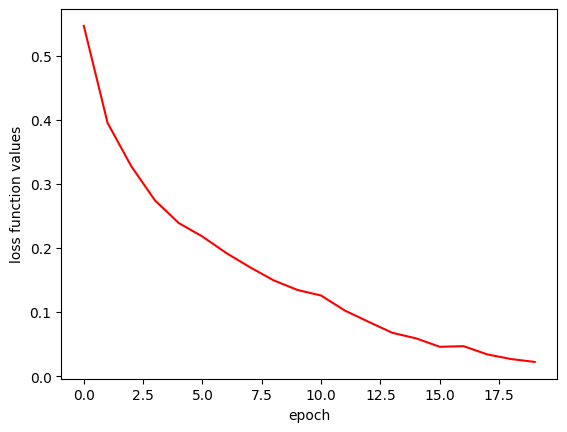

In [ ]:
hidden_units=30 # nodos de capas ocultas iniciales

# create model
model = models.Sequential()

# aprimera capa oculta de 10 nodos
model.add(layers.Dense(input_dim=len(X.columns),
                       units=hidden_units,
                       activation=activation))
#segunda capa oculta de 10 nodos
model.add(layers.Dense(input_dim=hidden_units,
                       units=hidden_units,
                       activation=activation))

# ultima capa oculta de 1 nodo
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#traint the parameters
history = model.fit(X_train_scaled, y_train,
                    epochs=20,
                    batch_size=batch_size)

#evalute the accuracy
train_acc=model.evaluate(X_train_scaled, y_train, batch_size=32)[1]
test_acc=model.evaluate(X_test_scaled, y_test, batch_size=32)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss function values')
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.82      0.82        49
           1       0.79      0.80      0.80        41

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.81      0.81      0.81        90



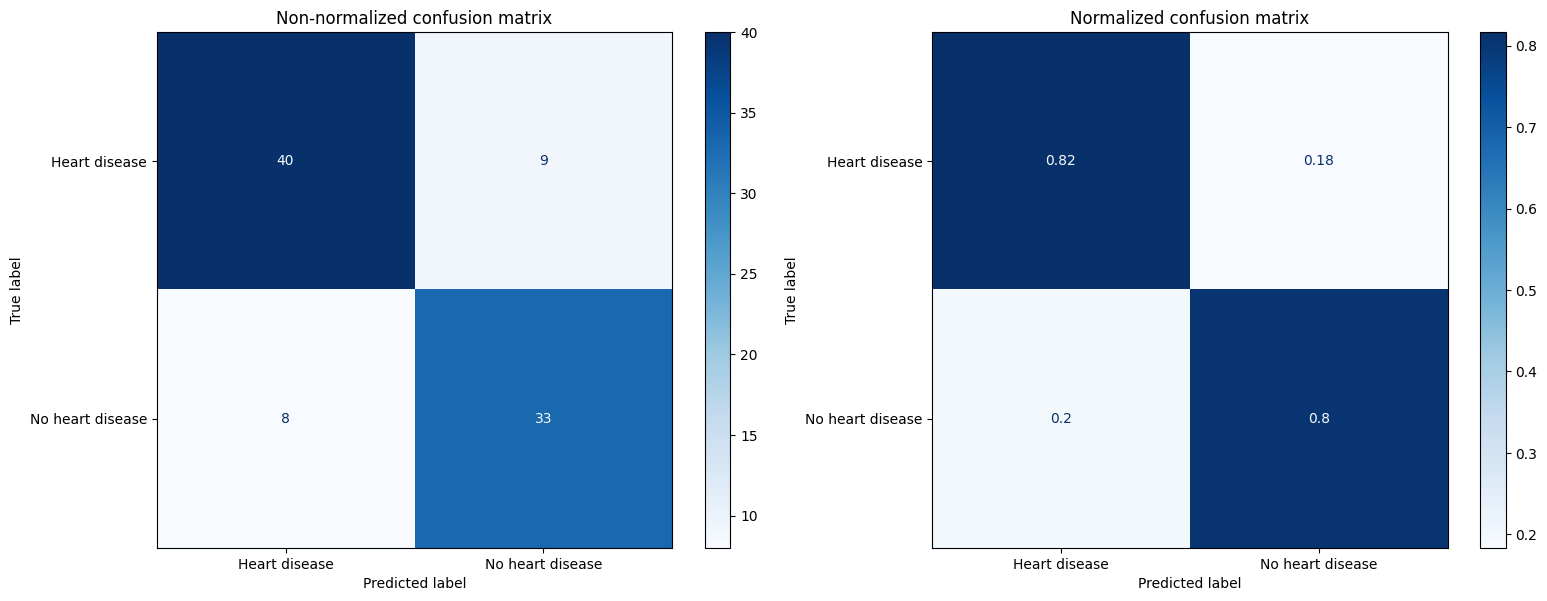

In [ ]:
test_predictions = (model.predict(X_test_scaled, verbose = 0) > 0.5).astype(int)
custom_confusion_matrix(y_test, test_predictions, ['Heart disease', 'No heart disease'])
print(classification_report(y_test, test_predictions))

### Estabilidad del entrenamiento y resultados promedio

In [ ]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for i in range(n):
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,verbose=False)
            train_accs.append(model.evaluate(x_train, y_train, batch_size=32,verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32,verbose=False)[1])
            progress_bar.update(1)
    print(f'\n Average train accuracy: {np.average(train_accs):.4f}')
    print(f'Average test accuracy: {np.average(test_accs):.4f}')
    return train_accs, test_accs

In [ ]:
 _, __=train_and_evaluate(model, X_train_scaled, y_train, X_test_scaled, y_test)

100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


 Average train accuracy: 1.0000
Average test accuracy: 0.7967


In [ ]:
 _, __=train_and_evaluate(model, X_train_scaled, y_train, X_test_scaled, y_test, n=30)

100%|██████████| 30/30 [00:15<00:00,  1.98it/s]


 Average train accuracy: 1.0000
Average test accuracy: 0.8000


In [ ]:
 _, __=train_and_evaluate(model,X_train,y_train,X_test,y_test,n=50)

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


 Average train accuracy: 0.8716
Average test accuracy: 0.7873


## Análisis

## Conclusiones